In [9]:
import nltk
from nltk import corpus
from nltk.collocations import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import wordnet
from nltk import punkt
from nltk.util import ngrams
from nltk import FreqDist

import re
from bs4 import BeautifulSoup
import unicodedata
from six import iteritems
from string import punctuation
from collections import Counter
import numpy as np
import calendar

In [10]:
import gensim
from gensim import corpora, models
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.similarities.docsim import MatrixSimilarity

import pandas as pd
from datetime import datetime

#Importing sklearn for bigram finder
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

%matplotlib inline


## Import and Clean Connect Report

In [12]:
report=pd.read_csv('connect_report.csv')

#trandforming the Date column in to pandas dates
report['Created Date']=pd.to_datetime(report['Created Date'])

#removing null records
report=report[pd.notnull(report['Created Date'])]
report=report[pd.notnull(report['Body'])]

#Removing HTML tags and codes
report['Body'] = report['Body'].apply(lambda x:BeautifulSoup(x))
report['Body'] = report['Body'].apply(lambda x:x.get_text())

#Removing tags/mentions
report['Body'] = report['Body'].apply(lambda x:re.sub('{@[\w\d]*}', '',x))

#Removing urls
report['Body'] = report['Body'].apply(lambda x:re.sub(r'^https?:\/\/.*[\r\n]*', '', x,flags=re.MULTILINE))

#Removing weird unicode characters
report['Body'] = report['Body'].apply(lambda x: x.encode('ascii', 'ignore'))

C:\Users\577931\AppData\Local\Continuum\anaconda2\lib\site-packages\bs4\__init__.py:181: UserWarning:

No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file C:\Users\577931\AppData\Local\Continuum\anaconda2\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")




## Report Generator

In [13]:
final_report=pd.DataFrame

#Use this function to create the final report for analysis
# Directions:
# 1. Set Group to a list of group names, a single name of a group, or All to use all groups
# 2. Set Type to a specific Feed Item Type or All
# 3. Set Start Date or leave blank(defaults to: 1/1/2017)
# 4. Set End Date or leave blank(defaults to: Today's date)

def report_generator(Group,Type,Date_start=pd.to_datetime("2017-01-01"),Date_finish=pd.to_datetime('today')):
    if type(Group) == list:
        final_report=report.loc[report['Name'].isin(Group)] 
    elif (Group=='All'):
        final_report=report
    else:
        final_report=report.loc[report['Name']==Group]
                                
    if (Type=='All'):
        final_report=final_report
    else:
        final_report=final_report.loc[final_report['Feed Item Type']==Type]
    
    if(Date_start=="2017-01-01" and Date_finish== pd.to_datetime('today')):
        final_report=final_report
    else:
        Date_start=pd.to_datetime(Date_start, utc=False)
        Date_finish=pd.to_datetime(Date_finish, utc=False)
        final_report=final_report[(final_report['Created Date'] > Date_start) & (final_report['Created Date']< Date_finish)]   
    return(final_report)


final_report=report_generator(['CPC+ All','NLT Internal Users'],'All',"2017-02-01","2017-04-01")

#sample final report
final_report.head(5)

,Network: Name,Name,Created By: Full Name,Created By: Company Name,Body,Created Date,Like Count,Comment Count,Feed Item Type
23,CPC Plus Connect,CPC+ All,Jon Regis,NJ,does everyone have portal access\n,2017-02-02,2.0,47.0,Text Post
24,CPC Plus Connect,CPC+ All,Stephanie Hardin,OH,I am trying to figure out how to document/trac...,2017-02-03,11.0,34.0,Text Post
25,CPC Plus Connect,CPC+ All,Sam Gottuso,BAH,We appreciate your participation in the Care M...,2017-02-03,2.0,4.0,Content Post
26,CPC Plus Connect,CPC+ All,Juliana Fritschel,CO,How is a group created within CPC+ Connect? I ...,2017-02-03,1.0,0.0,Text Post
27,CPC Plus Connect,NLT Internal Users,Bridget Lalley Ryder,NaN,Attention all CPC+ practices! Are there other ...,2017-02-03,0.0,0.0,Link Post


## Tokenizer Function

In [14]:
##Stop word and lemmatizer creation (PLEASE add to stop where you see fit)
stop = stopwords.words('english')
stop.append("cpc+")
stop.append("hi")
stop.append("hello")
stop.append("also")
stop.append("anyone")
stop.append("et")
stop.append("please")
stop.append("would")
stop.append("should")
stop.append("would")
stop.append("march")
stop.append("february")
stop.append("everyone")

wnl = WordNetLemmatizer() 

In [15]:
#this function tokenizes text (single and bigrams), removes stop word and punctuation, and lemmatizes the tokens
def tokenizer(text, extend_bigrams = True):
 
    tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text.lower())]
    
    tokens = []
    
    for token_by_sent in tokens_:
        tokens += token_by_sent
 
    tokens = list(filter(lambda t: t not in stop, tokens))
    tokens = list(filter(lambda t: t not in punctuation, tokens))
    tokens = list(filter(lambda t: t not in [u"'s", u"n't",u"'ve",u"'re",u"'d",u"'ll",u"'m", u"u", 
                                             u"...", u"''", u'``', u'\u2014', u'\u2026', u'\u2013'], tokens))
     
    filtered_tokens = []
    for token in tokens:
        token = wnl.lemmatize(token)
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
 
    filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))
   
    if extend_bigrams == True:
        
        bigrm = nltk.bigrams(filtered_tokens)
        bi_tokens = []
        for a, b in bigrm:
            bi_tok = ' '.join((a, b))
            bi_tokens.append(bi_tok)

        filtered_tokens.extend(bi_tokens)
    
    return filtered_tokens

In [16]:
#tokenizes final report
final_report['tokens'] = final_report['Body'].map(tokenizer)

#sample tokens
final_report.head()

,Network: Name,Name,Created By: Full Name,Created By: Company Name,Body,Created Date,Like Count,Comment Count,Feed Item Type,tokens
23,CPC Plus Connect,CPC+ All,Jon Regis,NJ,does everyone have portal access\n,2017-02-02,2.0,47.0,Text Post,"[portal, access, portal access]"
24,CPC Plus Connect,CPC+ All,Stephanie Hardin,OH,I am trying to figure out how to document/trac...,2017-02-03,11.0,34.0,Text Post,"[trying, figure, document/track, use, cmf, pay..."
25,CPC Plus Connect,CPC+ All,Sam Gottuso,BAH,We appreciate your participation in the Care M...,2017-02-03,2.0,4.0,Content Post,"[appreciate, participation, care, management, ..."
26,CPC Plus Connect,CPC+ All,Juliana Fritschel,CO,How is a group created within CPC+ Connect? I ...,2017-02-03,1.0,0.0,Text Post,"[group, created, within, connect, saw, post, t..."
27,CPC Plus Connect,NLT Internal Users,Bridget Lalley Ryder,NaN,Attention all CPC+ practices! Are there other ...,2017-02-03,0.0,0.0,Link Post,"[attention, practice, payer, region, currently..."


In [17]:
##Bi-Grams using Sci-Kit Learn
##Finding bigrams and frequencies across all data

single_tokens = final_report['Body'].apply(lambda x: tokenizer(x, extend_bigrams = False))
unlisted_report=single_tokens.apply(lambda x: ','.join(x))

word_vectorizer=CountVectorizer(ngram_range=(1,2), analyzer='word')
word_vectorizer_fit=word_vectorizer.fit_transform(unlisted_report)

frequencies=sum(word_vectorizer_fit).toarray()[0]

total_post_counter=pd.DataFrame(frequencies,index=word_vectorizer.get_feature_names(),columns=['frequency'])

filtered_post_counter = total_post_counter[total_post_counter['frequency']>10].copy()

filtered_post_counter.sort_values(by=['frequency'],ascending=False, inplace=True)
filtered_post_counter.head(15)


,frequency
practice,103
care,92
patient,86
group,59
question,50
reporting,46
risk,43
health,31
management,30
join,30


In [18]:
#Take a list of the top 10 most frequent words and then track their usage throughout the report period.

def single_day_tracker(report):
    
    #Create the top 10 list
    single_tokens = final_report['Body'].apply(lambda x: tokenizer(x, extend_bigrams = False))
    unlisted_report=single_tokens.apply(lambda x: ','.join(x))

    word_vectorizer=CountVectorizer(ngram_range=(1,2), analyzer='word')
    word_vectorizer_fit=word_vectorizer.fit_transform(unlisted_report)

    frequencies=sum(word_vectorizer_fit).toarray()[0]

    total_post_counter=pd.DataFrame(frequencies,index=word_vectorizer.get_feature_names(),columns=['frequency'])

    filtered_post_counter = total_post_counter[total_post_counter['frequency']>10].copy()

    filtered_post_counter.sort_values(by=['frequency'],ascending=False, inplace=True)
    top_words = filtered_post_counter.head(5).copy()
    
    top_words_listed=list(top_words.index)


    #Okay now figure out what the frequency was each day
    unique_dates=set(report['Created Date'])
    list_dates=sorted(list(unique_dates))
    list_df_name=list(xrange(0,len(list_dates)))
    list_df=[]
    new_df=pd.DataFrame
    for i in xrange(0,len(list_dates)):
        date_report=report.loc[report['Created Date']==list_dates[i]]
        unlisted_report_date=date_report['tokens'].apply(lambda x: ', '.join(x))
        word_vectorizer_fit_date=word_vectorizer.fit_transform(unlisted_report_date)
        frequencies_date=sum(word_vectorizer_fit_date).toarray()[0]
        bigrams_counter_date=pd.DataFrame(frequencies_date,index=word_vectorizer.get_feature_names(),columns=['frequency'])
        bigrams_date_listed=list(bigrams_counter_date.index)
        finder=(bigrams_counter_date.index.isin(top_words.index))
        slimmed=(bigrams_counter_date[finder])
        slimmed['word']=slimmed.index
        slimmed['date']=list_dates[i]
        slimmed['date']=pd.to_datetime(slimmed['date'])
        list_df_name[i]=slimmed
        list_df.append(list_df_name[i])
    new_df=pd.concat(list_df)
    new_df.index=xrange(0,len(new_df['word']))
    return(new_df)         
            
top_words=single_day_tracker(final_report)


C:\Users\577931\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\577931\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\577931\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

## Keyword Retrieval

In [19]:
#this function returns n keywords from specfied token list
def get_keywords(tokens, num):
    return Counter(tokens).most_common(num)

In [20]:
#iterates through all text bodies and prints the raw text and the top 5 most common words
for i,t in final_report['tokens'].iteritems():
    print(final_report['Body'][i])
    print( get_keywords(t,10))
    print

does everyone have portal access

[('access', 1), ('portal access', 1), ('portal', 1)]

I am trying to figure out how to document/track our use of the CMF payments. I was wondering if we will just be required to submit an excel document with our expenditures or will additional documentation be required? I have looked everywhere to find clarification and am not seeing anything. Any thoughts? 

[('required', 2), ('document/track use', 1), ('seeing', 1), ('documentation', 1), ('figure', 1), (u'cmf payment', 1), ('wondering required', 1), ('use cmf', 1), ('looked everywhere', 1), (u'expenditure additional', 1)]

We appreciate your participation in the Care Management Webinar. Click to download the webinar slides, post additional questions and continue the conversation with others here. A video recording will be forthcoming next week.

[('webinar', 2), ('recording forthcoming', 1), ('video recording', 1), ('video', 1), ('conversation others', 1), ('care management', 1), ('download', 1), ('f

In [21]:
#this functions prints the most common words by Feed Item Type
def keywords_bytype(feed_type):
    tokens = final_report[final_report['Feed Item Type'] == feed_type]['tokens']
    count_type = len(tokens)
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10), count_type

In [22]:
#iterates through all text bodies abd prints most common words by Feed Item Type
for t in set(final_report['Feed Item Type']):
    print('Category :', t)
    print('Top 10 Keywords:', keywords_bytype(t)[0])
    print('# of Posts:', keywords_bytype(t)[1])
    print('---')

('Category :', 'Advanced Text Post')
('Top 10 Keywords:', [('announcement', 3), ('important', 2), ('important announcement', 2), ('feed', 1), ('set', 1), ('show', 1), ('check newsletter', 1), ('newsletter', 1), ('check', 1), ('announcement test', 1)])
('# of Posts:', 4)
---
('Category :', 'Link Post')
('Top 10 Keywords:', [(u'practice', 20), ('health', 15), (u'group', 14), ('care', 13), ('join', 12), (u'patient', 10), ('step', 10), ('risk', 9), ('pm', 9), (u'question', 8)])
('# of Posts:', 22)
---
('Category :', 'Text Post')
('Top 10 Keywords:', [(u'patient', 71), (u'practice', 71), ('care', 66), (u'question', 33), ('reporting', 30), ('risk', 27), ('know', 21), (u'need', 21), ('thank', 20), (u'provider', 19)])
('# of Posts:', 140)
---
('Category :', 'Poll')
('Top 10 Keywords:', [('file', 2), ('better', 2), (u'practice', 2), ('link', 2), (u'user', 2), (u'care practitioner', 1), (u'program', 1), (u'practice provide', 1), ('better file', 1), ('seeing', 1)])
('# of Posts:', 3)
---
('Catego

## TF-IDF

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

In [24]:
#create a vectorizer object for our data with min docs. = 2, max feats. = 10K, and single and paired words
vectorizer = TfidfVectorizer(min_df=4, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 1))
vz = vectorizer.fit_transform(list(final_report['Body']))

In [25]:
#create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [26]:
#low tfidf scores
tfidf.sort_values(by=['tfidf'], ascending=True).head(15)

,tfidf
practice,2.064211
care,2.255266
patient,2.406497
question,2.634756
reporting,2.771957
check,3.040221
need,3.079442
available,3.079442
u,3.120264
delivery,3.162823


In [27]:
#high tfidf scores
tfidf.sort_values(by=['tfidf'], ascending=False).head(15)

,tfidf
event available,4.688879
submit,4.688879
management fee,4.688879
additional,4.688879
page bring,4.688879
strategy,4.688879
empaneled patient,4.688879
clicking link,4.688879
pm webinar,4.688879
total number,4.688879


## Correlated Words

In [28]:
##Constructing a collocation finder
#Measuring PMI (https://en.wikipedia.org/wiki/Pointwise_mutual_information)
#Measures the association that these words aren't just randomly next to each other--- 
#look at the count of each word and then the count of the words together to make the PMI score

finder=BigramCollocationFinder.from_documents(final_report['tokens'])
bigram_measures=nltk.collocations.BigramAssocMeasures()
score_collocation=finder.nbest(bigram_measures.pmi,15)

print(score_collocation)

[('//www.surveymonkey.com/r/hqtrzl3', 'attend patient'), ('11th april', 'april may'), ('1pm', 'discussion today'), ('1st', 'qtr'), ('1st qtr', 'qtr care'), ('24th/volume', 'cpc+side'), ('24th/volume cpc+side', 'cpc+side newsletter'), ('2day meeting', 'meeting train'), ('4:00pm registration', 'registration found'), ('4:00pm sponsored', 'sponsored office'), ('a.ics', 'ical'), ('a.ics ical', 'ical calendar'), ('a1c', u'analyzer'), (u'a1c analyzer', u'analyzer spirometer'), ('aafp', "'risk-stratified")]


In [29]:
scored = finder.score_ngrams(bigram_measures.pmi)
sorted_scored=sorted(bigram for bigram, score in scored)

print(sorted_scored[1:10])

[("'risk-stratified care", 'care management'), ('//www.surveymonkey.com/r/hqtrzl3', 'attend patient'), ('1-800-medicare', 'forward'), ('1-800-medicare forward', 'forward copy'), ('11th', 'april'), ('11th april', 'april may'), ('1pm', 'discussion today'), ('1st', 'qtr'), ('1st qtr', 'qtr care')]


In [30]:
##allows the user to search for two words in the scores list and print the index
def word_finder(x,y):
    for i, v in enumerate(scored):
        if v[0] == (x,y):
            return i
        elif v[0] == (y,x):
            return i

In [31]:
def single_word_finder(x,y,mode='single'):
    scores_e=list(enumerate(scored))
    index_list=[]
    final_list=[]
    if(mode=='double'):
        for i, v in enumerate(scored):
            if v[0] == (x,y):
                return scores_e[i]
            elif v[0] == (y,x):
                return scores_e[i]
    elif(mode=='single'):
        for i, v in enumerate(scored):
            if(scores_e[i][1][0][0]) == x or scores_e[i][1][0][1] == x or scores_e[i][1][0][0]==y or scores_e[i][1][0][1]==y:
                index_list.append(i)
        for j in index_list:
            final_list.append(scores_e[j])
        return final_list
        
        
single_word_finder('management','care','single')

[(5411, (('management', u'fee'), 8.49668736697885)),
 (5441, (('management', 'created consent'), 8.496687366978847)),
 (5442, (('management', 'pull'), 8.496687366978847)),
 (5443, (('management', 'staffing'), 8.496687366978847)),
 (5444, (('management', 'surely'), 8.496687366978847)),
 (5460, (('self', 'management'), 8.496687366978847)),
 (5470, (('weight', 'management'), 8.496687366978847)),
 (5907, (('medication', 'management'), 7.496687366978849)),
 (5913, (('management', u'effort'), 7.496687366978848)),
 (5914, (('management', 'understanding'), 7.496687366978848)),
 (6195, (('management', 'encourage'), 6.911724866257693)),
 (6344, (('care', u'manager'), 6.57385522750131)),
 (6345, (('care', 'utilization'), 6.57385522750131)),
 (6346, (('continuity', 'care'), 6.57385522750131)),
 (6347, (('longitudinal', 'care'), 6.57385522750131)),
 (6348, (("'risk-stratified", 'care'), 6.5738552275013085)),
 (6349, ((u'administrator', 'care'), 6.5738552275013085)),
 (6350, (('apart', 'care'), 6.57

In [32]:
##uses the word_finder function to pull out the correlation (or some type of score) between two words
try:
    print("The association between the two words is",scored[word_finder("able","assist")][1])
except:
    print("Choose a new word pair!")

('The association between the two words is', 7.796247648837756)


In [33]:
##Visualizing the results of the bigram finder
def graphing_single_word_finder(word1,word2='',mode='single'):
    graphing_data=single_word_finder(word1,'','single')
    graphing_data=pd.Series(graphing_data)
    score_list=[]
    non_word1_list=[]
    for i,v in graphing_data.iteritems():
        if(graphing_data[i][1][0][0]!=word1):
            non_word1_list.append(graphing_data[i][1][0][0])
        elif(graphing_data[i][1][0][1])!=word1:
            non_word1_list.append(graphing_data[i][1][0][1])
        score_list.append(graphing_data[i][1][1])
    final_graphing=pd.concat([pd.Series(non_word1_list),pd.Series(score_list)],axis=1)
    final_graphing.columns=['Word','PMI_Score']
    sns.mpl.rc("figure", figsize=(9,4))
    word_graph=sns.stripplot(x="Word", y="PMI_Score", data=final_graphing, size = 8)
    loc, labels = plt.xticks()
    word_graph.set_xticklabels(labels, rotation=90)
    #tooltip = plugins.PointLabelTooltip(final_graphing, final_graphing['Word'])
    #plugins.connect(word_graph,tooltip)


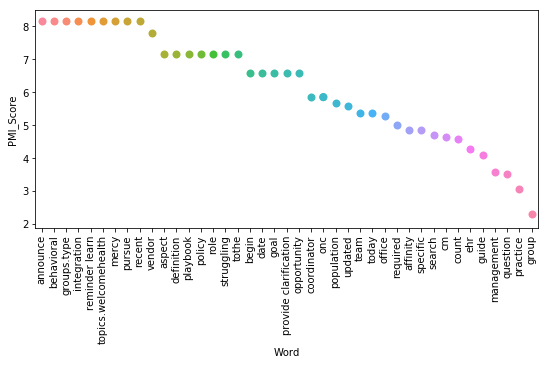

In [34]:
graphing_single_word_finder('health',mode='single')

In [35]:
graphing_data=single_word_finder('care','','single')
graphing_series=pd.Series(graphing_data)

graphing_series[1][1][1]



6.57385522750131

In [36]:
##Graphing most popular word by day

test_date=top_words['date'][0]

#sns.pointplot(x='date',y='frequency',hue='word',data=top_words)

##okay so this is super busy but we're getting there

#ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))



test_float=float(test_date.month)+(float(test_date.day)/100)

test_float

##There must be a faster/better way to do this

top_words['new_date']=float

for i in xrange(0,len(top_words['date'])):
    top_words['new_date'][i]=float(top_words['date'][i].month)+(float(top_words['date'][i].day)/100)
    


C:\Users\577931\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\Users\577931\AppData\Local\Continuum\anaconda2\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



(2.02, 2.3)

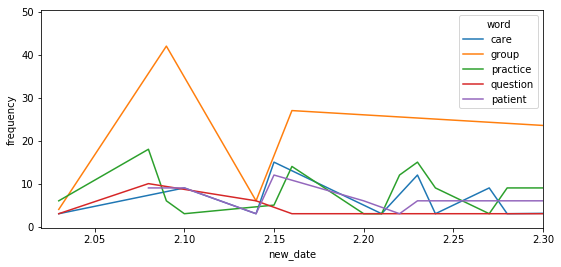

In [37]:
top_words['frequency']=top_words['frequency'].astype(float)

top_words

top_words.dtypes
ax=sns.tsplot(time='new_date',value='frequency',condition='word',unit='word',data=top_words)

#will need to figure out how to do some auto scaling on the plt xlim to get a better view than the default
plt.xlim(2.02,2.3)

## Sentiment Analysis

In [38]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *


nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

C:\Users\577931\AppData\Local\Continuum\anaconda2\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\577931\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [39]:
sid=SentimentIntensityAnalyzer()
##so this will make a list with all of the sentences analyzed--- compound is the final score ranging from -1 to 1... and then you can get a breakdown of each individual score (how neg/netural/post it is)
##Vader should be the package that we use (formulated for social media results+sweet ass name) but not passing my eye test so far
##if we edit the vader_lexicon.txt file we could add words or change the weighting...
##only would need the token and a score... doesn't use the list of ratings or the standard deviation
##suggested adds-- question should be negative... figure also
##but could you do this on a script basis-- can't have everyone doing this manually
listed_sents=final_report['Body'].tolist()
all_sents=[]
for sentence in listed_sents:
    print(sentence)
    ss=sid.polarity_scores(sentence)
    all_sents.append(ss)
    for i in sorted(ss):
        print(i,ss[i])


does everyone have portal access

('compound', 0.0)
('neg', 0.0)
('neu', 1.0)
('pos', 0.0)
I am trying to figure out how to document/track our use of the CMF payments. I was wondering if we will just be required to submit an excel document with our expenditures or will additional documentation be required? I have looked everywhere to find clarification and am not seeing anything. Any thoughts? 

('compound', 0.5204)
('neg', 0.0)
('neu', 0.935)
('pos', 0.065)
We appreciate your participation in the Care Management Webinar. Click to download the webinar slides, post additional questions and continue the conversation with others here. A video recording will be forthcoming next week.

('compound', 0.7096)
('neg', 0.0)
('neu', 0.836)
('pos', 0.164)
How is a group created within CPC+ Connect? I saw  's post and think this would be great to start building these groups!

('compound', 0.75)
('neg', 0.0)
('neu', 0.748)
('pos', 0.252)
Attention all CPC+ practices! Are there other payers in your r

('compound', 0.1154)
('neg', 0.0)
('neu', 0.969)
('pos', 0.031)
Are we supposed to register for Open Office Hours or are these just if we have specific questions

('compound', 0.0)
('neg', 0.0)
('neu', 1.0)
('pos', 0.0)
Check out the latest ?On the Plus Side? weekly newsletter for timely information and resources!

('compound', 0.0)
('neg', 0.0)
('neu', 1.0)
('pos', 0.0)
Anyone else confused on the reporting process?

('compound', -0.3182)
('neg', 0.277)
('neu', 0.723)
('pos', 0.0)
Did you attend the ?Patient and Caregiver Engagement? webinar? If so, we?d like to hear from you! Your confidential feedback is important to us and will help improve future learning events. Please take this short survey to provide your feedback.https://www.surveymonkey.com/r/HQTRZL3

('compound', 0.9406)
('neg', 0.0)
('neu', 0.67)
('pos', 0.33)
CPC Classic was approved for Maintenance of Certification under American Board of Family Medicine. Does anyone know if that is the case with CPC+? I have a couple of 

In [40]:
#assign a netural/negative/positive to the final report
#THIS IS COMPLETLEY ARBITRARY, I was going to use the max score for each dictionary entry, but most of them were netural.. using compound in stead

final_report['sentiment']=str
final_report['sentiment_score']=int

for i in range(0,len(all_sents)):
    final_report['sentiment_score'].iloc[i]=all_sents[i]['compound']
    if(all_sents[i]['compound']<-.3):
        final_report['sentiment'].iloc[i]= "negative"
    elif(all_sents[i]['compound']>.3):
        final_report['sentiment'].iloc[i]="positive"
    else:
        final_report['sentiment'].iloc[i]="neutral"
        

C:\Users\577931\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [41]:
sentiment_list=['Body','sentiment','sentiment_score']

sentiment_report=final_report[sentiment_list]



print("percentage of netural sentences=",float(len(sentiment_report[sentiment_report['sentiment']=='neutral']))/float(len(sentiment_report)),"percent of positive sentences=",float(len(sentiment_report[sentiment_report['sentiment']=='positive']))/float(len(sentiment_report)),"percent of negative sentences=",float(len(sentiment_report[sentiment_report['sentiment']=='negative']))/float(len(sentiment_report)))

('percentage of netural sentences=', 0.35175879396984927, 'percent of positive sentences=', 0.5979899497487438, 'percent of negative sentences=', 0.05025125628140704)


In [42]:
##Pie Graph

init_notebook_mode(connected=True)


labels=['Neutral','Positive','Negative']
values=[(len(sentiment_report[sentiment_report['sentiment']=='neutral'])),(len(sentiment_report[sentiment_report['sentiment']=='positive'])),(len(sentiment_report[sentiment_report['sentiment']=='negative']))]

sentiment_pie=go.Pie(labels=labels,values=values)

offline.iplot([sentiment_pie],filename='sentiment pie')

## Topic Modeling

In [43]:
final_report.shape

(199, 12)

In [44]:
token_list = final_report['Body'].map(tokenizer)

# get dictionary for the corpus
corp_dict = corpora.Dictionary(token_list)

# remove words that only appear once
once_ids = [tokenid for tokenid, docfreq in iteritems(corp_dict.dfs) if docfreq == 1]
corp_dict.filter_tokens(once_ids)
corp_dict.compactify()  # remove gaps in id sequence after words that were removed
print(corp_dict)

Dictionary(969 unique tokens: [u'support practice', u'provider longer', u'care compacts/collaborative', u'code', u'patient risk']...)


In [45]:
corpus_master = [corp_dict.doc2bow(token) for token in token_list]

In [46]:
k = 150  # number of topics
min_prob = 0.3  # controls filtering the topics returned for a document
lda = models.LdaModel(corpus_master, id2word=corp_dict, num_topics=k, passes=3, minimum_probability=min_prob)

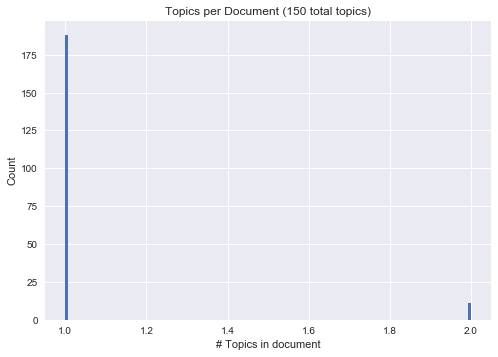

In [47]:
def plot_topics_per_doc(model, corpus, k):
    plt.style.use('seaborn')
    n_topics = []
    for doc in corpus_master:
        n_topics.append(len(lda.get_document_topics(doc)))
    n_topics
    
    plt.title('Topics per Document (' + str(k) + ' total topics)')
    plt.xlabel('# Topics in document')
    plt.ylabel('Count')
    plt.hist(n_topics, bins=k)
    plt.show()
    
plot_topics_per_doc(lda, corpus_master, k)

In [48]:
import operator

# returns DataFrame with topics and # of documents they appear in, sorted most to fewest
def get_topic_freq(lda, corpus):
    topic_counts = dict.fromkeys(range(k), 0)
    for doc in corpus:
        for topic in lda.get_document_topics(doc):
            topic_counts[topic[0]] += 1
    return pd.DataFrame(sorted(topic_counts.items(), key=operator.itemgetter(1), reverse=True), columns=['Topic', 'n_docs'])

# plot a sorted, horizontal bar chart of top topics
def plot_top_topics(lda, topic_freq, n):
    plt.style.use('seaborn')
    top = topic_freq[:n]
    if (n>25):
        plt.figure(figsize=(20, 22))
        plt.rcParams.update({'font.size': 40})
        plt.yticks(range(n), [[x[0] for x in lda.show_topic(t)] for t in top['Topic']], fontsize = 20)
    else:
        plt.yticks(range(n), [[x[0] for x in lda.show_topic(t)] for t in top['Topic']])
    plt.barh(range(n), top['n_docs'])
    
    plt.gca().invert_yaxis()
    plt.title('Top ' + str(n) +' topics')
    plt.xlabel('# documents containing topic')
    
    plt.show()

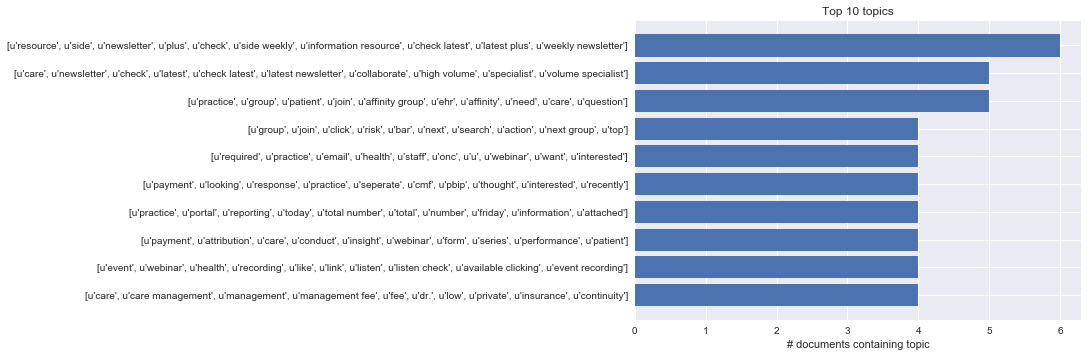

In [49]:
topic_freq = get_topic_freq(lda, corpus_master)
plot_top_topics(lda, topic_freq, 10)

In [50]:
def assign_topic_to_doc(lda, corpus, report):
    i= 0
    report['Topic'] = "NA"

    for doc in corpus:
        doc_topic = lda.get_document_topics(doc)[0][0]
        topic_list = []
        for x in lda.show_topic(doc_topic):
            topic_list.append(x[0])
        report['Topic'].iloc[i] = topic_list
        i += 1
    return report


In [51]:
topics_report = assign_topic_to_doc(lda, corpus_master, final_report)

In [52]:
topics_report.head(5)

,Network: Name,Name,Created By: Full Name,Created By: Company Name,Body,Created Date,Like Count,Comment Count,Feed Item Type,tokens,sentiment,sentiment_score,Topic
23,CPC Plus Connect,CPC+ All,Jon Regis,NJ,does everyone have portal access\n,2017-02-02,2.0,47.0,Text Post,"[portal, access, portal access]",neutral,0,"[access, portal, able, site, practice, practic..."
24,CPC Plus Connect,CPC+ All,Stephanie Hardin,OH,I am trying to figure out how to document/trac...,2017-02-03,11.0,34.0,Text Post,"[trying, figure, document/track, use, cmf, pay...",positive,0.5204,"[required, practice, email, health, staff, onc..."
25,CPC Plus Connect,CPC+ All,Sam Gottuso,BAH,We appreciate your participation in the Care M...,2017-02-03,2.0,4.0,Content Post,"[appreciate, participation, care, management, ...",positive,0.7096,"[webinar, question, others, additional questio..."
26,CPC Plus Connect,CPC+ All,Juliana Fritschel,CO,How is a group created within CPC+ Connect? I ...,2017-02-03,1.0,0.0,Text Post,"[group, created, within, connect, saw, post, t...",positive,0.75,"[group, connect, great, start, created, post, ..."
27,CPC Plus Connect,NLT Internal Users,Bridget Lalley Ryder,NaN,Attention all CPC+ practices! Are there other ...,2017-02-03,0.0,0.0,Link Post,"[attention, practice, payer, region, currently...",positive,0.6939,"[practice, cm, payer, participating, payer rou..."


In [53]:
topics_report.to_excel('output.xlsx')